# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 123 kB 7.1 MB/s 
     |████████████████████████████████| 90 kB 10.1 MB/s 
     |████████████████████████████████| 176 kB 27.2 MB/s 
     |████████████████████████████████| 131 kB 30.0 MB/s 
     |████████████████████████████████| 1.2 MB 29.1 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
     |████████████████████████████████| 79 kB 11.5 MB/s 
     |████████████████████████████████| 7.8 MB 53.4 MB/s 
     |████████████████████████████████| 138 kB 58.9 MB/s 
     |████████████████████████████████| 127 kB 71.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatibl

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm.auto import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD'

dev-v2.0.json  train-v2.0.json	utils_squad_evaluate.py  utils_squad.py


In [ ]:
!ls /drive/My\ Drive/Medium

ls: cannot access '/drive/My Drive/Medium': No such file or directory


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/')

In [7]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [8]:
# %cd '../../../../../'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
input_file = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/train-v2.0.json'
all_examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [11]:
all_examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [12]:
round(0.2*len(all_examples))

26064

Take 20% data

In [13]:
examples = all_examples[:round(0.2*len(all_examples))]

In [14]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [15]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
7929,56dcecb79a695914005b9486,Who became president of the Congo in 1968?,"[Marien, Ngouabi,, who, had, participated, in,...",Marien Ngouabi,0,1,False
7930,56dcecb79a695914005b9487,What did the Congo's name become under Ngouabi?,"[Marien, Ngouabi,, who, had, participated, in,...",People's Republic of the Congo,27,31,False
7931,56dcecb79a695914005b9488,What did the National Revolutionary Movement's...,"[Marien, Ngouabi,, who, had, participated, in,...",Congolese Labour Party,47,49,False
7932,56dcecb79a695914005b9489,In what year was a coup attempted against Ngou...,"[Marien, Ngouabi,, who, had, participated, in,...",1972,57,57,False
7933,56dcecb79a695914005b948a,On what date was Ngouabi assassinated?,"[Marien, Ngouabi,, who, had, participated, in,...","March 16, 1977",62,64,False
7934,5ad0049777cf76001a68676a,"Who left the presidency on December 31, 1968?","[Marien, Ngouabi,, who, had, participated, in,...",,-1,-1,True
7935,5ad0049777cf76001a68676b,Who became president after Denis Sassou Nguesso?,"[Marien, Ngouabi,, who, had, participated, in,...",,-1,-1,True
7936,5ad0049777cf76001a68676c,What did the Congo's name change to under Deni...,"[Marien, Ngouabi,, who, had, participated, in,...",,-1,-1,True
7937,5ad0049777cf76001a68676d,When did Denis Sassou Nguesso survive a coup?,"[Marien, Ngouabi,, who, had, participated, in,...",,-1,-1,True
7938,5ad0049777cf76001a68676e,When was Joachim Yhombi-Opango assassinated?,"[Marien, Ngouabi,, who, had, participated, in,...",,-1,-1,True


In [16]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [17]:
print_squad_sample(train_data)

CONTEXT: 
For his second album, Late Registration (2005), he collaborated with film score composer Jon
Brion and drew influence from non-rap influences such as English trip hop group Portishead.
Blending West's primary soulful hip hop production with Brion's elaborate chamber pop orchestration, the
album experimentally incorporated a wide array of different genres and prominent orchestral elements, including
string arrangements, piano chords, brass flecks, and horn riffs among other symphonic instrumentation. It
also incorporated a myriad of foreign and vintage instruments not typical in popular music,
let alone hip hop, such as a celesta, harpsichord, Chamberlin, CS-80 analog synthesizer, Chinese
bells and berimbau, vibraphones, and marimba. Rolling Stone described Late Registration as West claiming
"the whole world of music as hip-hop turf" chronicling the album as "his mad
quest to explode every cliché about hip-hop identity." Critic Robert Christgau wrote that "there's
never been h

In [18]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
1206,56d3ab7e2ccc5a1400d82dfd,How often is the Grand prix du disque de F. Ch...,"[Numerous, recordings, of, Chopin's, works, ar...",every five years.,64,66,False,67,86
8545,56ddb92966d3e219004dacaa,Which characters on The Rocky and Bullwinkle S...,"[The, name, Wayback, Machine, was, chosen, as,...",Mr. Peabody and Sherman,37,40,False,66,105
9771,5ad3057d604f3c001a3fdad2,What position do cardinal deacons not hold?,"[The, cardinal, deacons, are, the, lowest-rank...",,-1,-1,True,36,43
8094,56dd14af9a695914005b94c8,When was the Congo allowed back into the Kimbe...,"[The, current, administration, presides, over,...",2007,74,74,False,75,59
7854,5acff5ca77cf76001a686634,What year was President Denis Sassou Nguesso o...,"[The, region, was, dominated, by, Bantu-speaki...",,-1,-1,True,96,53


In [19]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.77608962553714%


In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 953597.47B/s]


In [21]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [22]:
cached_features_file = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/cache_train'

In [23]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [24]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [25]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [26]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [27]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/checkpoint*-[0-9]*'))

In [28]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [29]:
if len(checkpoints) > 0:
  global_step = int(checkpoints[-1].split('-')[-1])
  ckpt_name = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:11<00:00, 39019990.95B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [30]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0262, -0.0209,  0.0056,  ...,  0.0099,  0.0040,  0.0085],
        [ 0.0109,  0.0170,  0.0006,  ...,  0.0514,  0.0153, -0.0065]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [31]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [32]:
len(dataset)

28080

In [33]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 28080
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 1755


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1755 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 1.7061200550198554
Saving model checkpoint to /content/drive/MyDrive/TSAI_END2/Session14/SQuAD/checkpoint-1000


In [34]:
output_dir = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/checkpoint-1000'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [35]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/checkpoint-1000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

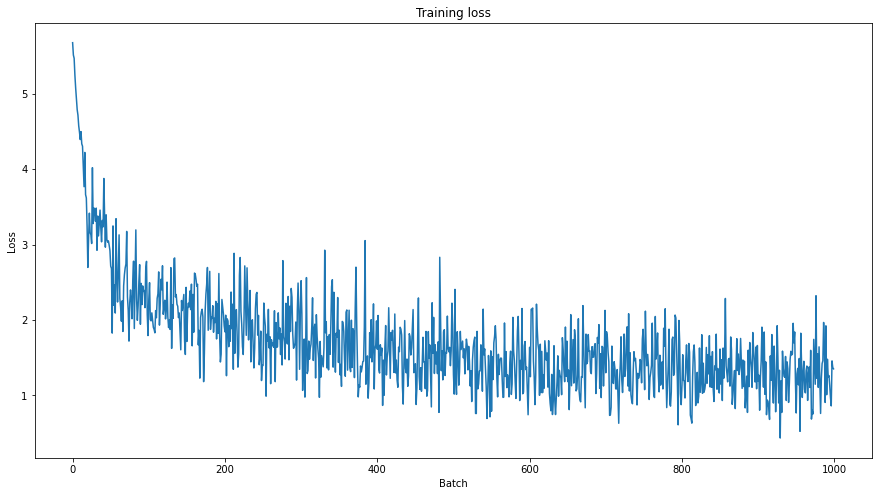

In [36]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [37]:
input_file = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/cache_validation'

# val_examples = val_examples[:round(0.2*len(val_examples))]
# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [38]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [39]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [40]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/null_odds.json"
  output_dir = "/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [41]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

{
  "exact": 45.23709256295797,
  "f1": 49.62238723150311,
  "total": 11873,
  "HasAns_exact": 68.23549257759784,
  "HasAns_f1": 77.0186578271989,
  "HasAns_total": 5928,
  "NoAns_exact": 22.304457527333895,
  "NoAns_f1": 22.304457527333895,
  "NoAns_total": 5945,
  "best_exact": 56.935904994525394,
  "best_exact_thresh": -10.495759069919586,
  "best_f1": 58.76720531853934,
  "best_f1_thresh": -6.954275846481323
}


In [43]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 45.23709256295797}, {'f1': 49.62238723150311}, {'total': 11873}, {'HasAns_exact': 68.23549257759784}, {'HasAns_f1': 77.0186578271989}, {'HasAns_total': 5928}, {'NoAns_exact': 22.304457527333895}, {'NoAns_f1': 22.304457527333895}, {'NoAns_total': 5945}, {'best_exact': 56.935904994525394}, {'best_exact_thresh': -10.495759069919586}, {'best_f1': 58.76720531853934}, {'best_f1_thresh': -6.954275846481323}]


**Evaluate on any text**

In [45]:
with open('/content/drive/MyDrive/TSAI_END2/Session14/SQuAD/predictions.json') as f:
    predictions = json.load(f)

print("*"*40)
print("Sample Answers predicted by BERT")
print("*"*40)
i = 0
for example in val_examples[:10]:
    ques = example.question_text
    ans = predictions[example.qas_id]

    print(f"{i+1}) Question: {ques}")
    print(f"Predicted Answer: {ans}")
    print("-"*40)

    i += 1

****************************************
Sample Answers predicted by BERT
****************************************
1) Question: In what country is Normandy located?
Predicted Answer: France
----------------------------------------
2) Question: When were the Normans in Normandy?
Predicted Answer: 10th and 11th centuries
----------------------------------------
3) Question: From which countries did the Norse originate?
Predicted Answer: Denmark, Iceland and Norway
----------------------------------------
4) Question: Who was the Norse leader?
Predicted Answer: Rollo
----------------------------------------
5) Question: What century did the Normans first gain their separate identity?
Predicted Answer: 10th century
----------------------------------------
6) Question: Who gave their name to Normandy in the 1000's and 1100's
Predicted Answer: The Normans
----------------------------------------
7) Question: What is France a region of?
Predicted Answer: Normandy
-----------------------------